In [36]:
# Gerekli kütüphaneleri yüklenmesi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_absolute_error, mean_squared_error
from prophet import Prophet
from pmdarima import auto_arima


In [37]:
# 1. Veriyi oku ve temizle
df = pd.read_excel(r"C:\\Users\\ilayd\\OneDrive\\Masaüstü\\zaman serisi\\hava_durumu_verileri.xlsx")

df["Yüksek Sıcaklık"] = df["Yüksek Sıcaklık"].str.replace("°C", "").astype(int)
df["Düşük Sıcaklık"] = df["Düşük Sıcaklık"].str.replace("°C", "").astype(int)
df["Tarih"] = pd.to_datetime(df["Tarih"], format="%Y-%m-%d")

ts_data = df[["Tarih", "Yüksek Sıcaklık"]].copy()
ts_data.set_index("Tarih", inplace=True)


In [38]:
# Zaman serisini oluştur
ts_data = df[["Tarih", "Yüksek Sıcaklık"]].copy()
ts_data.set_index("Tarih", inplace=True)

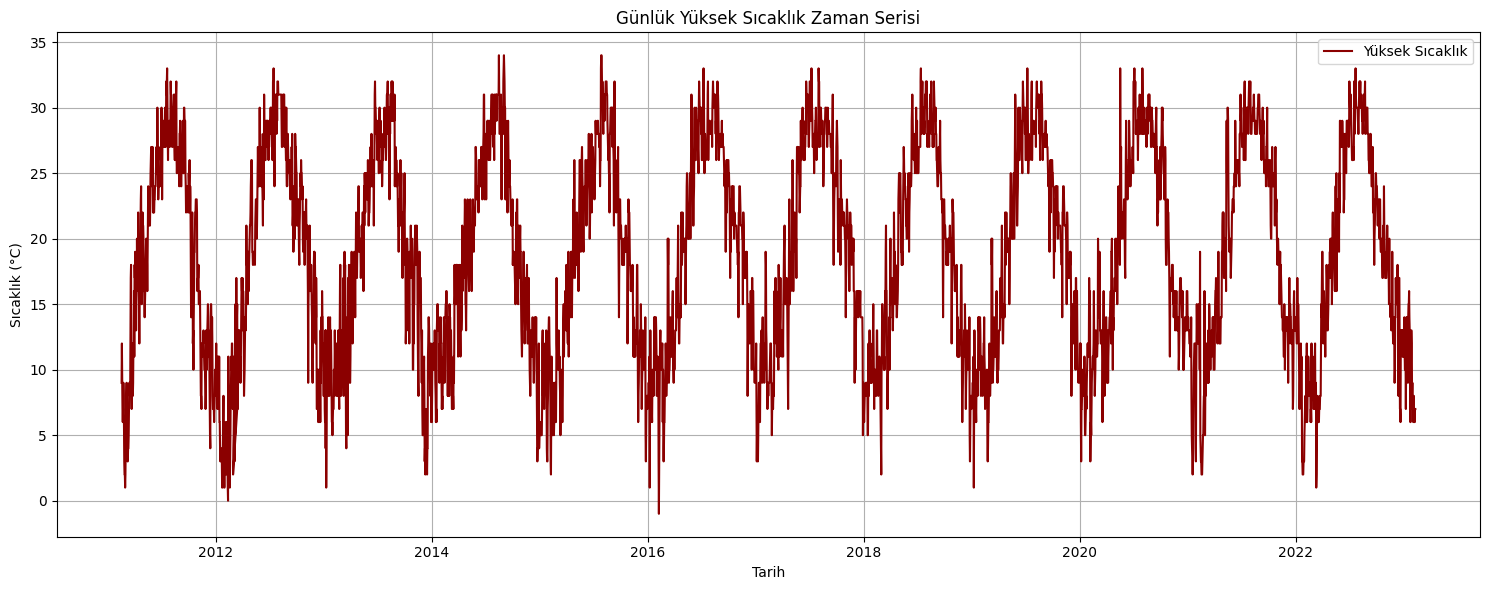

In [39]:
#Günlük Zaman Serisi Grafiği
plt.figure(figsize=(15,6))
plt.plot(ts_data, label="Yüksek Sıcaklık", color="darkred")
plt.title("Günlük Yüksek Sıcaklık Zaman Serisi")
plt.xlabel("Tarih")
plt.ylabel("Sıcaklık (°C)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

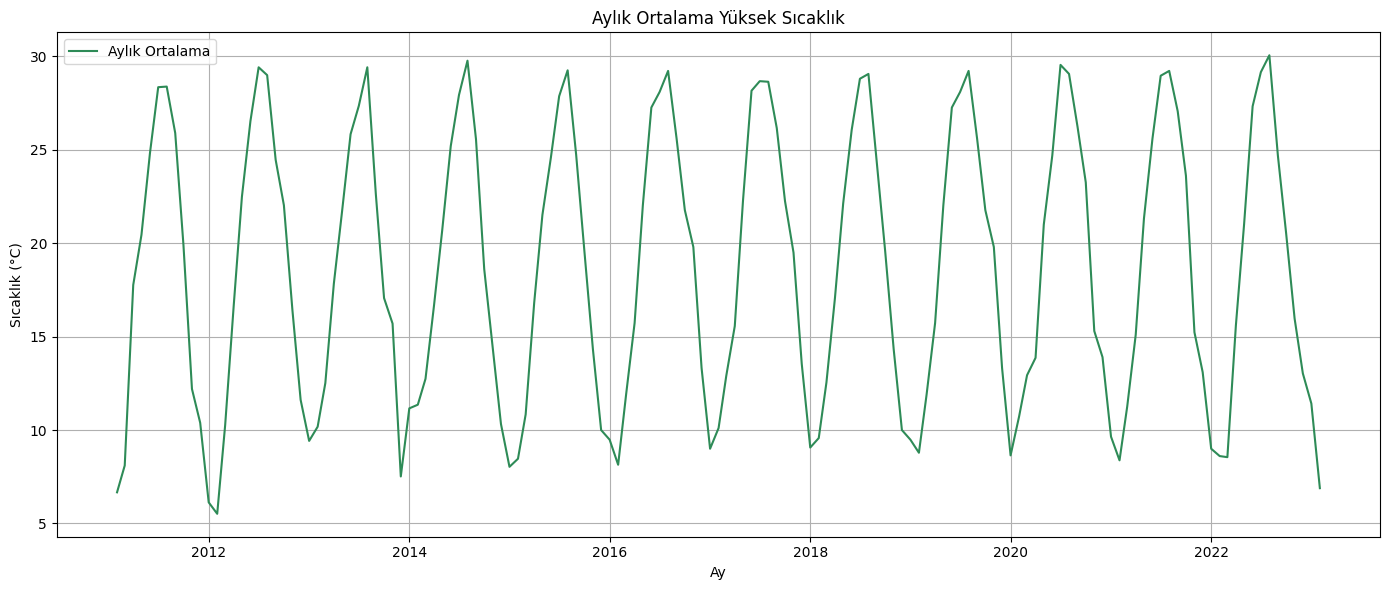

In [40]:
# Aylık Ortalama Sıcaklık Grafiği
df["Ay"] = df["Tarih"].dt.to_period("M")
monthly_avg = df.groupby("Ay")["Yüksek Sıcaklık"].mean().reset_index()
monthly_avg["Ay"] = monthly_avg["Ay"].dt.to_timestamp()

plt.figure(figsize=(14,6))
plt.plot(monthly_avg["Ay"], monthly_avg["Yüksek Sıcaklık"], color='seagreen', label="Aylık Ortalama")
plt.title("Aylık Ortalama Yüksek Sıcaklık")
plt.xlabel("Ay")
plt.ylabel("Sıcaklık (°C)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

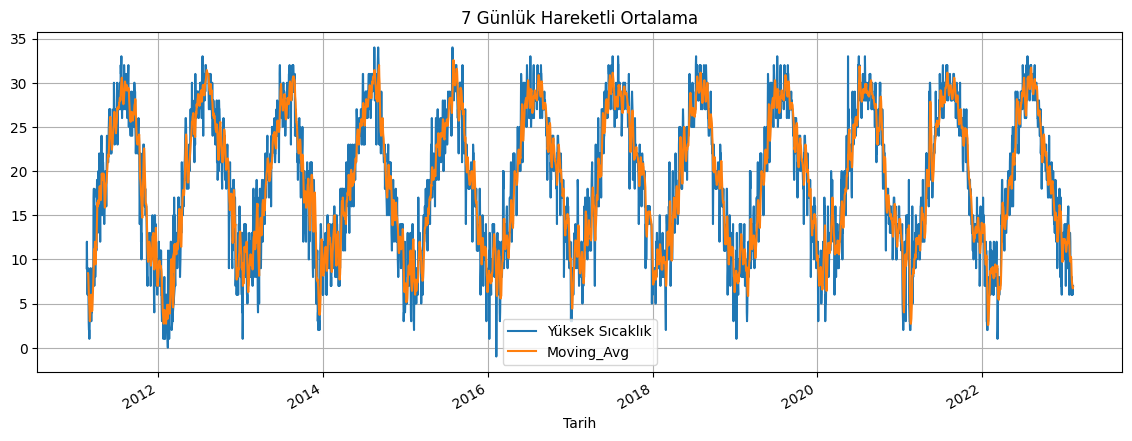

In [41]:
# Hareketli Ortalama (7 Günlük)
ts_data["Moving_Avg"] = ts_data["Yüksek Sıcaklık"].rolling(window=7).mean()
ts_data[["Yüksek Sıcaklık", "Moving_Avg"]].plot(figsize=(14,5), title="7 Günlük Hareketli Ortalama")
plt.grid()
plt.show()

In [42]:
# 2. Durağanlık testi
adf_result = adfuller(ts_data["Yüksek Sıcaklık"])
print("ADF Test İstatistiği:", adf_result[0])
print("p-değeri:", adf_result[1])
if adf_result[1] < 0.05:
    print("Sonuç: Seri durağandır.")
else:
    print("Sonuç: Seri durağan değildir.")


ADF Test İstatistiği: -3.607146593453691
p-değeri: 0.005625860910778215
Sonuç: Seri durağandır.


17:11:36 - cmdstanpy - INFO - Chain [1] start processing
17:11:37 - cmdstanpy - INFO - Chain [1] done processing


             ds       yhat  yhat_lower  yhat_upper
4394 2023-03-02   9.897976    6.397592   13.590672
4395 2023-03-03  10.160821    6.523095   13.954698
4396 2023-03-04  10.338125    6.442048   13.924760
4397 2023-03-05  10.365417    6.461366   13.783013
4398 2023-03-06  10.493180    6.841131   14.410700
4399 2023-03-07  10.624535    6.883943   14.485960
4400 2023-03-08  10.765015    7.358476   14.370081
4401 2023-03-09  10.862480    6.990259   14.492642
4402 2023-03-10  11.106426    7.580192   15.051826
4403 2023-03-11  11.258789    7.533757   14.742114


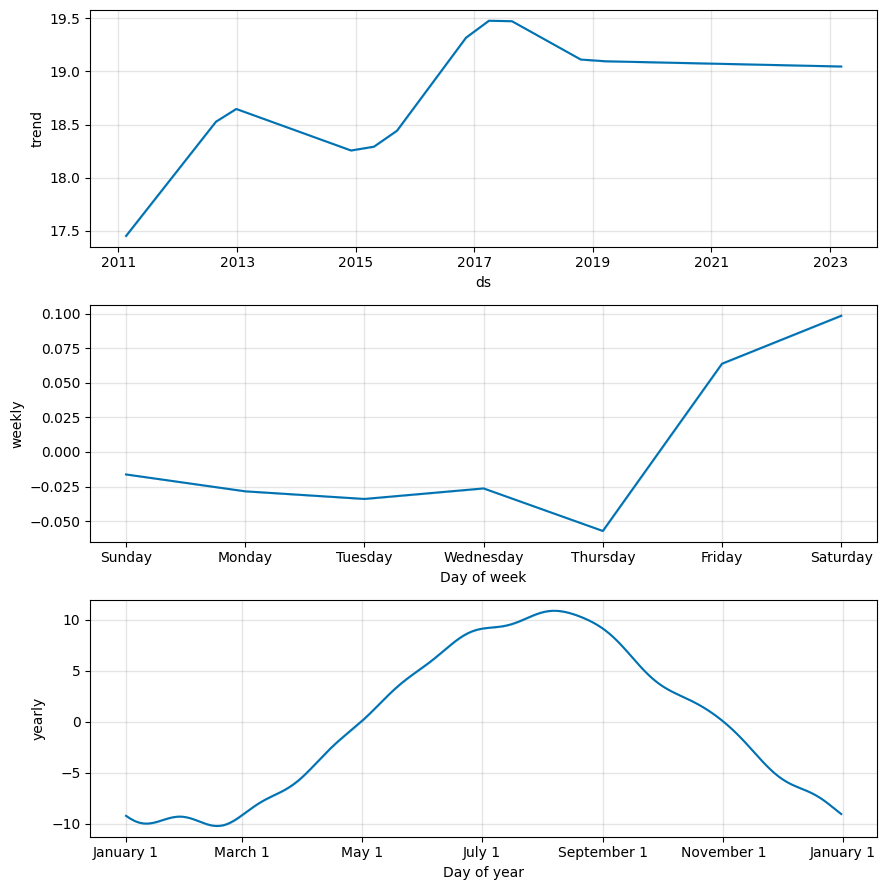

In [43]:
# Prophet Modelinin Uygulanması ve Bileşenlerinin Görselleştirilmesi
# Prophet formatına veri hazırlama
df = ts_data.reset_index()[["Tarih", "Yüksek Sıcaklık"]]
df.columns = ["ds", "y"]

# Prophet modelini oluştur
prophet_model = Prophet(yearly_seasonality=True, daily_seasonality=False)
prophet_model.fit(df)

# Tahmin oluştur
future = prophet_model.make_future_dataframe(periods=30)
forecast = prophet_model.predict(future)

# Bileşenleri görselleştir
prophet_model.plot_components(forecast)

# Tahmin tablosundan özet bilgiler
print(forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail(10))


In [44]:
# SARIMA(2,1,2)(0,1,2)[12] modeli, sıcaklık serisinin hem trend hem de mevsimsel bileşenlerini aynı anda modellemek üzere kurulmuştur. Modelin başarı kriterleri özetlenmiştir.
model = SARIMAX(ts_data["Yüksek Sıcaklık"], 
                order=(2,1,2), 
                seasonal_order=(0,1,2,12),
                enforce_stationarity=False,
                enforce_invertibility=False)

sarima_result = model.fit(disp=False)

# Çıktı özeti 
print(sarima_result.summary())


                                     SARIMAX Results                                      
Dep. Variable:                    Yüksek Sıcaklık   No. Observations:                 4421
Model:             SARIMAX(2, 1, 2)x(0, 1, 2, 12)   Log Likelihood               -9627.177
Date:                            Tue, 27 May 2025   AIC                          19268.355
Time:                                    17:13:39   BIC                          19313.050
Sample:                                         0   HQIC                         19284.125
                                           - 4421                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7119      0.014    125.759      0.000       1.685       1.739
ar.L2         -0.7166      0.014   

17:13:40 - cmdstanpy - INFO - Chain [1] start processing
17:13:40 - cmdstanpy - INFO - Chain [1] done processing


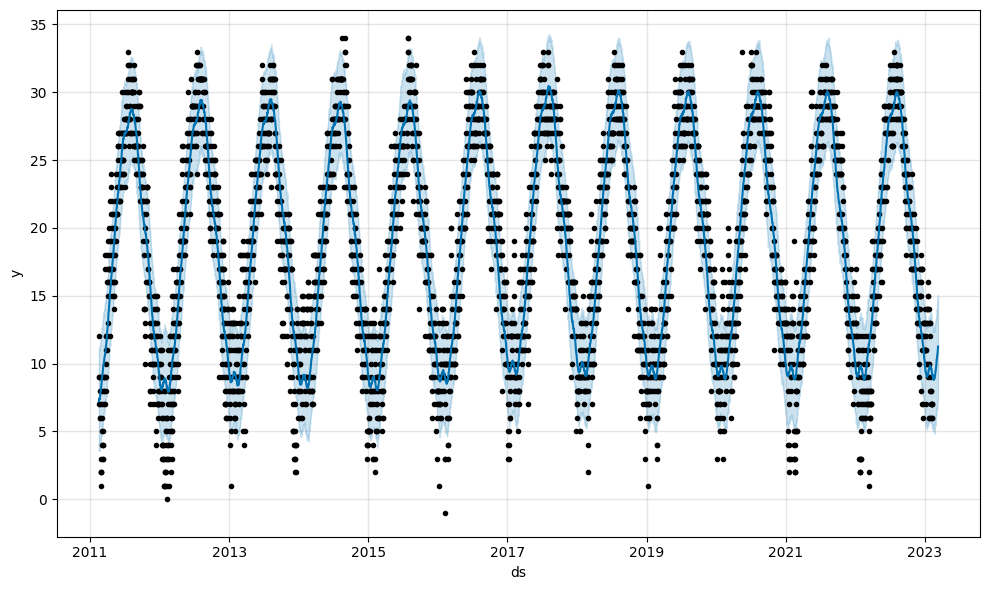

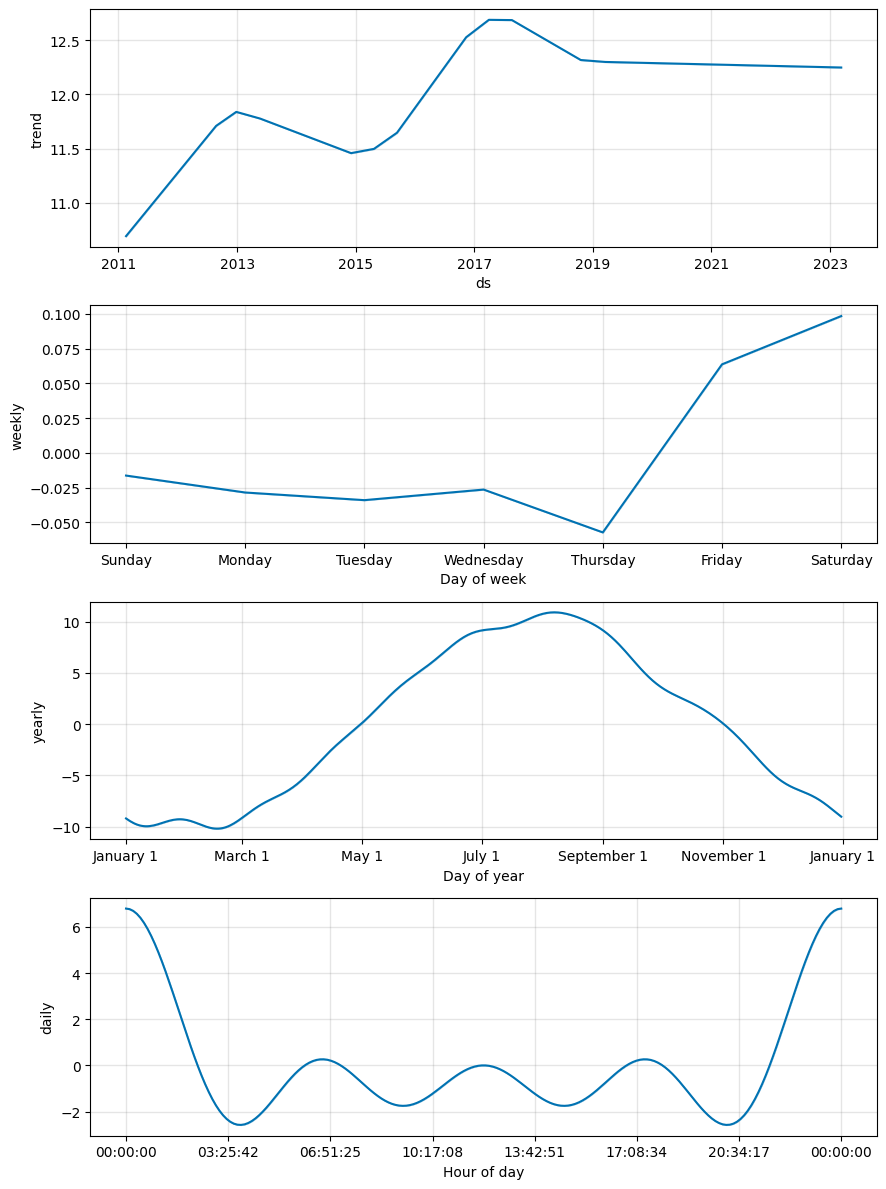

In [ ]:
#  Prophet modeli tekrar uygulanarak ileriye dönük 30 günlük tahmin yapılmış, hem genel tahmin grafiği hem de model bileşenlerinin ayrı ayrı etkisi görselleştirilmiştir.
# Prophet Tahmin Grafiği
from prophet import Prophet

# Prophet formatı için veri setini hazırlama
df_prophet = ts_data.reset_index().rename(columns={"Tarih": "ds", "Yüksek Sıcaklık": "y"})

# Model kurulumu
prophet_model = Prophet(daily_seasonality=True, yearly_seasonality=True)
prophet_model.fit(df_prophet)

# Gelecekteki 30 günü tahmin et
future = prophet_model.make_future_dataframe(periods=30)
forecast = prophet_model.predict(future)

# Tahmin Grafiği
fig1 = prophet_model.plot(forecast)
fig2 = prophet_model.plot_components(forecast)  # Sezon, trend, tatil bileşenleri

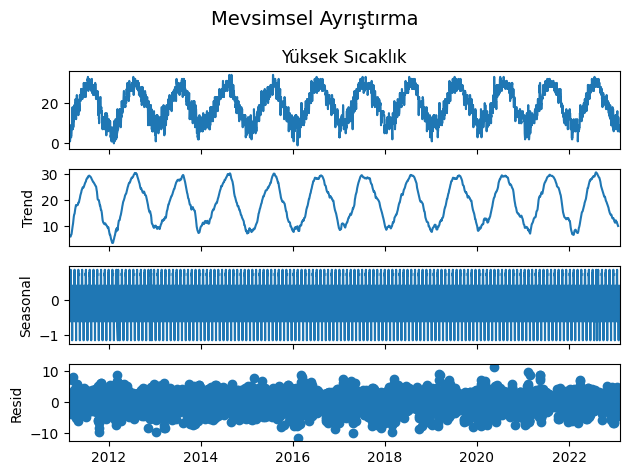

In [46]:
# # Zaman serisinin trend, mevsimsellik ve artık bileşenlerini görselleştirmek amacıyla, mevsimsel ayrıştırma uygulanmıştır. Böylece serinin yapısı daha net analiz edilebilir
ts_data.index = pd.to_datetime(ts_data.index)

# Eksik değerleri doldur
ts_data["Yüksek Sıcaklık"] = ts_data["Yüksek Sıcaklık"].interpolate()

# Mevsimsel ayrıştırma (additive model ile)
decomp = seasonal_decompose(ts_data["Yüksek Sıcaklık"], model='additive', period=30)

# Grafik
decomp.plot()
plt.suptitle("Mevsimsel Ayrıştırma", fontsize=14)
plt.tight_layout()
plt.show()


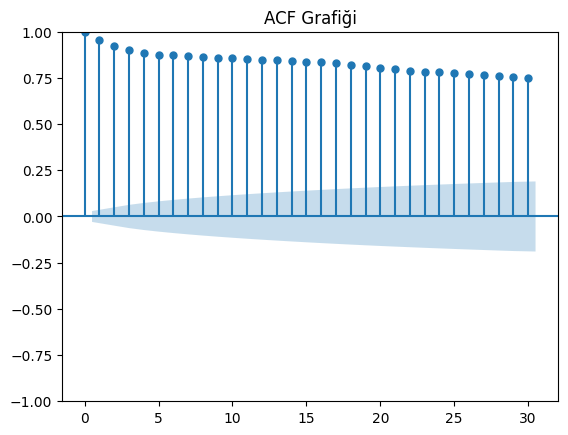

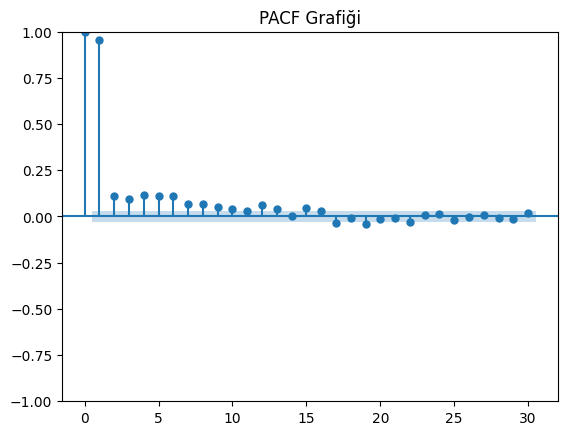

In [47]:
# # Model seçiminde kullanılmak üzere, serideki otokorelasyon ve kısmi otokorelasyon yapıları ACF ve PACF grafikleri aracılığıyla analiz edilmiştir.
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_data["Yüksek Sıcaklık"], lags=30)
plt.title("ACF Grafiği")
plt.show()

plot_pacf(ts_data["Yüksek Sıcaklık"], lags=30)
plt.title("PACF Grafiği")
plt.show()

In [48]:
#ARIMA(2,1,2) modeli seriye uygulanmış ve sonraki 30 günlük tahmin değerleri elde edilmiştir.
# Bu tahminler, diğer yöntemlerle karşılaştırılmak üzere saklanmaktadır.

arima_model = ARIMA(ts_data["Yüksek Sıcaklık"], order=(2,1,2))
arima_result = arima_model.fit()

# 30 günlük tahmin
forecast_arima = arima_result.forecast(steps=30)
print(forecast_arima)


4421    7.404666
4422    7.652911
4423    7.792535
4424    7.856868
4425    7.869151
4426    7.845589
4427    7.797475
4428    7.732681
4429    7.656691
4430    7.573324
4431    7.485238
4432    7.394279
4433    7.301731
4434    7.208481
4435    7.115146
4436    7.022146
4437    6.929772
4438    6.838219
4439    6.747620
4440    6.658061
4441    6.569596
4442    6.482259
4443    6.396068
4444    6.311031
4445    6.227147
4446    6.144412
4447    6.062818
4448    5.982355
4449    5.903011
4450    5.824772
Name: predicted_mean, dtype: float64


In [49]:
# 5. Prophet Modeli (tüm veriyle)
df_prophet = ts_data.reset_index().rename(columns={"Tarih": "ds", "Yüksek Sıcaklık": "y"})
model_prophet = Prophet()
model_prophet.fit(df_prophet)
future = model_prophet.make_future_dataframe(periods=30)
forecast_prophet = model_prophet.predict(future)


17:13:47 - cmdstanpy - INFO - Chain [1] start processing
17:13:48 - cmdstanpy - INFO - Chain [1] done processing


In [50]:
# Bellek dostu bir tahmin elde etmek amacıyla sadece son 365 gün verisi ile SARIMA modeli kurulmuştur.
# Otomatik parametre seçimi için auto_arima() fonksiyonu kullanılmıştır.

ts_data_short = ts_data["Yüksek Sıcaklık"].last("365D")

# Sessiz çalışması için stdout yönlendirme
import contextlib, io
f = io.StringIO()
with contextlib.redirect_stdout(f):
    sarima_model = auto_arima(ts_data_short,
                               start_p=1, start_q=1,
                               max_p=3, max_q=3,
                               seasonal=True,
                               m=12, d=1, D=1,
                               max_order=6,
                               stepwise=True,
                               trace=False,
                               suppress_warnings=True,
                               error_action='ignore')

# Tahmin
forecast_sarima = sarima_model.predict(n_periods=30)

# Opsiyonel çıktı
print(sarima_model.summary())


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  381
Model:             SARIMAX(2, 1, 2)x(0, 1, 2, 12)   Log Likelihood                -783.451
Date:                            Tue, 27 May 2025   AIC                           1580.901
Time:                                    17:15:47   BIC                           1608.258
Sample:                                         0   HQIC                          1591.770
                                            - 381                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3821      0.086     -4.459      0.000      -0.550      -0.214
ar.L2          0.5874      0.080   

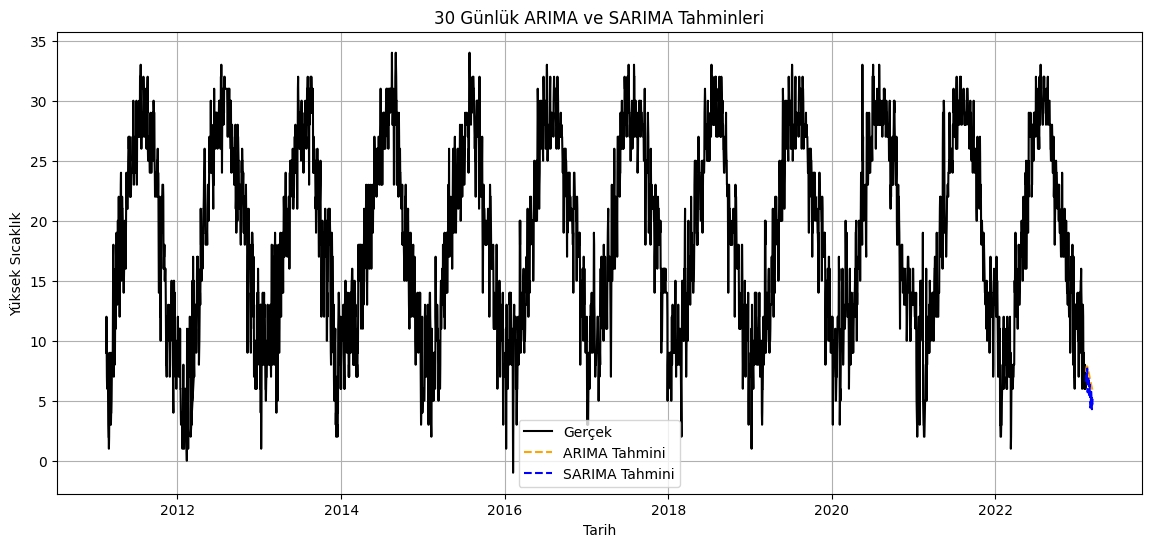

In [51]:
# 7. Grafiklerle tahmin karşılaştırması
forecast_dates = pd.date_range(start=ts_data.index[-1] + pd.Timedelta(days=1), periods=30)

plt.figure(figsize=(14,6))
plt.plot(ts_data.index, ts_data["Yüksek Sıcaklık"], label="Gerçek", color='black')
plt.plot(forecast_dates, forecast_arima, label="ARIMA Tahmini", linestyle='--', color='orange')
plt.plot(forecast_dates, forecast_sarima, label="SARIMA Tahmini", linestyle='--', color='blue')
plt.title("30 Günlük ARIMA ve SARIMA Tahminleri")
plt.xlabel("Tarih")
plt.ylabel("Yüksek Sıcaklık")
plt.legend()
plt.grid()
plt.show()

In [52]:
# 8. Hata Metrikleri (Son 30 güne göre) Daha düşük değerler, daha başarılı tahmin anlamına gelir.
true_values = ts_data["Yüksek Sıcaklık"][-30:]
arima_pred = arima_result.predict(start=len(ts_data)-30, end=len(ts_data)-1)
sarima_in_sample = sarima_model.predict_in_sample()

mae_arima = mean_absolute_error(true_values, arima_pred)
rmse_arima = np.sqrt(mean_squared_error(true_values, arima_pred))

mae_sarima = mean_absolute_error(true_values, sarima_in_sample[-30:])
rmse_sarima = np.sqrt(mean_squared_error(true_values, sarima_in_sample[-30:]))

print("ARIMA MAE:", round(mae_arima, 2))
print("ARIMA RMSE:", round(rmse_arima, 2))
print("SARIMA MAE:", round(mae_sarima, 2))
print("SARIMA RMSE:", round(rmse_sarima, 2))

ARIMA MAE: 1.55
ARIMA RMSE: 2.04
SARIMA MAE: 1.81
SARIMA RMSE: 2.15


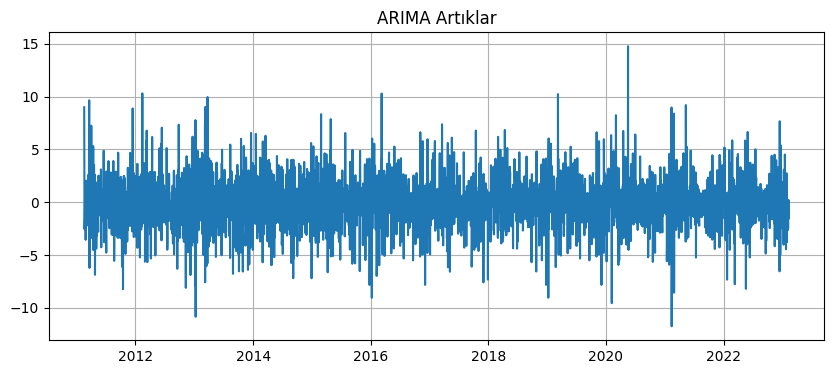

Ljung-Box Test Sonucu:
       lb_stat  lb_pvalue
10  15.217249    0.12434


In [53]:
# # ARIMA modelinin artıklarının rasgele dağılıp dağılmadığını değerlendirmek amacıyla
# zaman serisi grafiği ve Ljung-Box testi uygulanmıştır. Bu, modelin güvenilirliğini artırır.
resid = arima_result.resid

plt.figure(figsize=(10,4))
plt.plot(resid)
plt.title("ARIMA Artıklar")
plt.grid()
plt.show()

# Ljung-Box testi
from statsmodels.stats.diagnostic import acorr_ljungbox
ljung = acorr_ljungbox(resid, lags=[10], return_df=True)
print("Ljung-Box Test Sonucu:\n", ljung)

In [54]:
# Hata Metrikleri ve Model Kıyaslama
true_values = ts_data["Yüksek Sıcaklık"][-30:]
arima_pred = arima_result.predict(start=len(ts_data)-30, end=len(ts_data)-1)
sarima_pred = sarima_model.predict_in_sample()[-30:]

mae_arima = mean_absolute_error(true_values, arima_pred)
rmse_arima = np.sqrt(mean_squared_error(true_values, arima_pred))
mae_sarima = mean_absolute_error(true_values, sarima_pred)
rmse_sarima = np.sqrt(mean_squared_error(true_values, sarima_pred))

comparison_df = pd.DataFrame({
    "Model": ["ARIMA", "SARIMA"],
    "MAE": [mae_arima, mae_sarima],
    "RMSE": [rmse_arima, rmse_sarima]
})
print(comparison_df)


    Model       MAE      RMSE
0   ARIMA  1.550898  2.037435
1  SARIMA  1.812324  2.153522
